# House Prices: Advanced Regression Techniques
### Predict sales prices and practice feature engineering, RFs, and gradient boosting

### Импортирование библиотек, чтение данных и их первичный анализ

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
def ingnore_warn(*args, **kwargs):
    pass
warnings.warn = ingnore_warn
from matplotlib import pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_data = pd.read_csv("../Data/train.csv")
test_data = pd.read_csv("../Data/test.csv")

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Поле 'Id' никак не влияет на построение модели, поэтому уберем это поле из обучающей и тестовой выборки.

In [5]:
train_data.drop(['Id'],axis=1, inplace = True)
test_data.drop(['Id'],axis=1, inplace = True)

In [6]:
train_data.shape, test_data.shape

((1460, 80), (1459, 79))

### Изучение данных и их характеристик, а также их обработка

In [7]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Подсчет количества пропущенных значений по каждому из признаков для обучающей и тестовой выборки

In [8]:
train_data.isnull().sum().sort_values(ascending=False, inplace=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageType         81
GarageCond         81
GarageFinish       81
GarageQual         81
GarageYrBlt        81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
RoofMatl            0
Exterior1st         0
RoofStyle           0
ExterQual           0
Exterior2nd         0
YearBuilt           0
ExterCond           0
Foundation          0
YearRemodAdd        0
SalePrice           0
OverallCond         0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [9]:
test_data.isnull().sum().sort_values(ascending=False, inplace=False)

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
LotFrontage       227
GarageCond         78
GarageFinish       78
GarageYrBlt        78
GarageQual         78
GarageType         76
BsmtCond           45
BsmtExposure       44
BsmtQual           44
BsmtFinType1       42
BsmtFinType2       42
MasVnrType         16
MasVnrArea         15
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
BsmtFinSF2          1
BsmtFinSF1          1
BsmtUnfSF           1
TotalBsmtSF         1
Exterior2nd         1
SaleType            1
Exterior1st         1
                 ... 
YearBuilt           0
OverallCond         0
SaleCondition       0
HeatingQC           0
ExterCond           0
Foundation          0
YrSold              0
MoSold              0
MiscVal             0
PoolArea            0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF

#### Выделение целевой переменной, которую нужно предсказать и объединене обучаующей и тестовой выборки для обработки признаков.

1.880940746034036


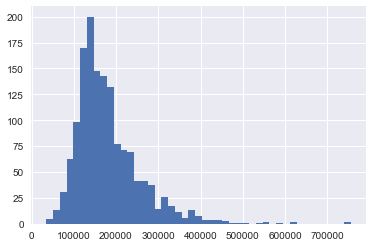

In [10]:
train_data['SalePrice'].hist(bins=45)
print(skew(train_data.SalePrice))

In [11]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

In [12]:
y = train_data['SalePrice']
train_data.drop(['SalePrice'], axis = 1, inplace = True)

In [13]:
train_data.shape, test_data.shape

((1460, 79), (1459, 79))

In [14]:
all_data = pd.concat([train_data, test_data], axis=0)

In [15]:
all_data.shape

(2919, 79)

#### Выделение числовых и категориальных признаков.

In [16]:
categorial_features = [prizn for prizn in train_data.columns if all_data[prizn].dtype.name == 'object']
numeric_features = [prizn for prizn in train_data.columns if all_data[prizn].dtype.name != 'object']
print(categorial_features, numeric_features, sep = '\n')

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Enclos

In [17]:
all_data[categorial_features].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,...,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,...,1723,1230,2604,2654,2641,4,329,95,2525,2402


In [18]:
all_data[numeric_features].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


#### Заполнение пропущенных значений вещественных признаков средним значением по столбцу

In [19]:
all_data = all_data.fillna(all_data.mean(axis=0))

In [20]:
all_data[numeric_features].count(axis=0)

MSSubClass       2919
LotFrontage      2919
LotArea          2919
OverallQual      2919
OverallCond      2919
YearBuilt        2919
YearRemodAdd     2919
MasVnrArea       2919
BsmtFinSF1       2919
BsmtFinSF2       2919
BsmtUnfSF        2919
TotalBsmtSF      2919
1stFlrSF         2919
2ndFlrSF         2919
LowQualFinSF     2919
GrLivArea        2919
BsmtFullBath     2919
BsmtHalfBath     2919
FullBath         2919
HalfBath         2919
BedroomAbvGr     2919
KitchenAbvGr     2919
TotRmsAbvGrd     2919
Fireplaces       2919
GarageYrBlt      2919
GarageCars       2919
GarageArea       2919
WoodDeckSF       2919
OpenPorchSF      2919
EnclosedPorch    2919
3SsnPorch        2919
ScreenPorch      2919
PoolArea         2919
MiscVal          2919
MoSold           2919
YrSold           2919
dtype: int64

#### Заполнение пропущенных значений категориальных признаков новой категорией

In [21]:
for one_prizn in categorial_features:
    all_data[one_prizn] = all_data[one_prizn].fillna('None')
    

In [22]:
all_data[categorial_features].count(axis=0)

MSZoning         2919
Street           2919
Alley            2919
LotShape         2919
LandContour      2919
Utilities        2919
LotConfig        2919
LandSlope        2919
Neighborhood     2919
Condition1       2919
Condition2       2919
BldgType         2919
HouseStyle       2919
RoofStyle        2919
RoofMatl         2919
Exterior1st      2919
Exterior2nd      2919
MasVnrType       2919
ExterQual        2919
ExterCond        2919
Foundation       2919
BsmtQual         2919
BsmtCond         2919
BsmtExposure     2919
BsmtFinType1     2919
BsmtFinType2     2919
Heating          2919
HeatingQC        2919
CentralAir       2919
Electrical       2919
KitchenQual      2919
Functional       2919
FireplaceQu      2919
GarageType       2919
GarageFinish     2919
GarageQual       2919
GarageCond       2919
PavedDrive       2919
PoolQC           2919
Fence            2919
MiscFeature      2919
SaleType         2919
SaleCondition    2919
dtype: int64

#### Векторизация категориальных признаков

In [23]:
all_data = pd.get_dummies(all_data)

In [24]:
all_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_New', 'SaleType_None', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=310)

#### Масштабирование вещественных признаков

In [25]:
all_data[numeric_features] = StandardScaler().fit_transform(all_data[numeric_features])

#### Окончательное формирование обучающей выборки и тестовых данных для модели

In [26]:
X_train = all_data[:train_data.shape[0]]
X_test = all_data[train_data.shape[0]:]
print(X_train.shape, X_test.shape, y.shape)

(1460, 310) (1459, 310) (1460,)


In [27]:
X_train, X_test, y

(      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
 0       0.067331    -0.202068 -0.217879     0.646183    -0.507284   1.046258   
 1      -0.873616     0.501870 -0.072044    -0.063185     2.188279   0.154764   
 2       0.067331    -0.061280  0.137197     0.646183    -0.507284   0.980221   
 3       0.302568    -0.436714 -0.078385     0.646183    -0.507284  -1.859351   
 4       0.067331     0.689587  0.518903     1.355551    -0.507284   0.947203   
 5      -0.167905     0.736516  0.500515    -0.772552    -0.507284   0.716075   
 6      -0.873616     0.267224 -0.010667     1.355551    -0.507284   1.079276   
 7       0.067331     0.000000  0.027123     0.646183     0.391237   0.055709   
 8      -0.167905    -0.859076 -0.513352     0.646183    -0.507284  -1.331059   
 9       3.125411    -0.906006 -0.348496    -0.772552     0.391237  -1.066912   
 10     -0.873616     0.032578  0.130856    -0.772552    -0.507284  -0.208437   
 11      0.067331     0.7365

### Подбор модели для обучения

#### Определим функции ошибок для оценки моделей машинного обучения

In [41]:
kfolds = KFold(n_splits = 5, shuffle = True, random_state = 11)


def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv= kfolds))
    
    

#### В качестве модели машинного обучения воспользуемся случайным лесом и алгоримом градиентного бустинга

In [30]:
from sklearn import ensemble
import xgboost as xgb

In [30]:
rfregr = ensemble.RandomForestRegressor(n_estimators=300, max_depth = 3, random_state = 5)
rfregr.fit(X_train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=5,
           verbose=0, warm_start=False)

In [31]:
rmse_cv(rfregr).mean()

0.19635153938756794

#### Посмотрим зависимость от количества деревьев

In [33]:
number_of_estimators = np.arange(30,500, 10)
rmse_scores = []
for one_tree in number_of_estimators:
    print(one_tree)
    rfregr = ensemble.RandomForestRegressor(n_estimators=one_tree, max_depth = 3, random_state = 4)
    rmse_scores.append(rmse_cv(rfregr).mean())

30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


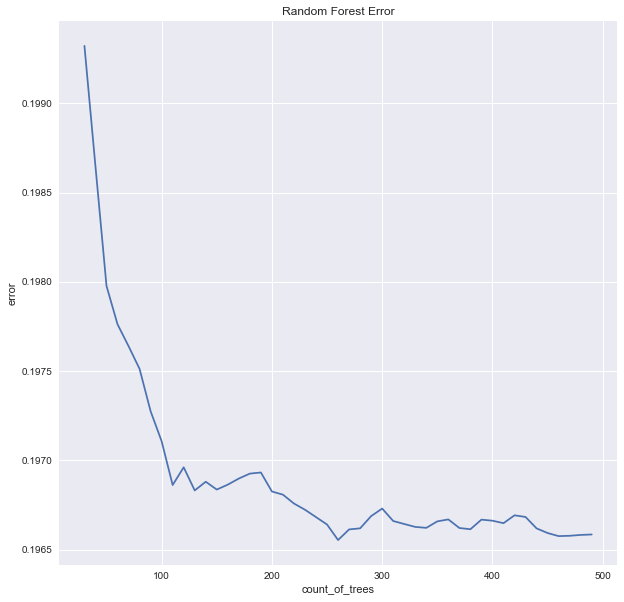

In [37]:
plt.figure(figsize=(10,10))
plt.plot(number_of_estimators, rmse_scores)
plt.xlabel('count_of_trees')
plt.ylabel('error')
plt.title('Random Forest Error')

#### Посмотрим зависимость от глубины дерева

In [38]:
number_of_depth = np.arange(1,30, 1)
rmse_scores_depth = []
for one_depth in number_of_depth:
    print(one_depth)
    rfregr = ensemble.RandomForestRegressor(n_estimators=460, max_depth = one_depth, random_state = 4)
    rmse_scores_depth.append(rmse_cv(rfregr).mean())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


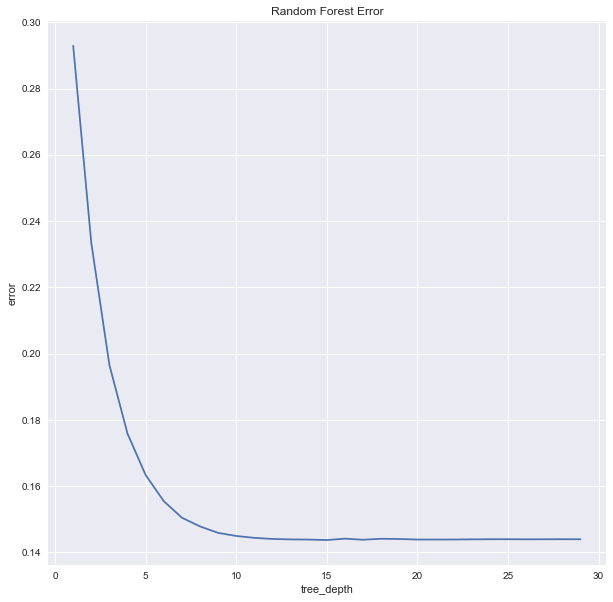

In [39]:
plt.figure(figsize=(10,10))
plt.plot(number_of_depth, rmse_scores_depth)
plt.xlabel('tree_depth')
plt.ylabel('error')
plt.title('Random Forest Error')

#### Обучим итоговый случайный лес с подобранными параметрами

In [40]:
rfregr = ensemble.RandomForestRegressor(n_estimators=460, max_depth = 15, random_state = 4)
rfregr.fit(X_train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=460, n_jobs=1, oob_score=False, random_state=4,
           verbose=0, warm_start=False)

In [41]:
rmse_cv(rfregr).mean()

0.14375371568106174

In [46]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

#### XGBoost Посмотрим зависимость от количества деревьев

In [32]:
number_of_trees = np.arange(50,4000,50)
rmse_scores_trees = []
for xgb_tree in number_of_trees:
    print(xgb_tree)
    model_xgb = xgb.XGBRegressor(n_estimators=xgb_tree, max_depth=3, learning_rate=0.1)
    rmse_scores_trees.append(rmse_cv(model_xgb).mean())

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950


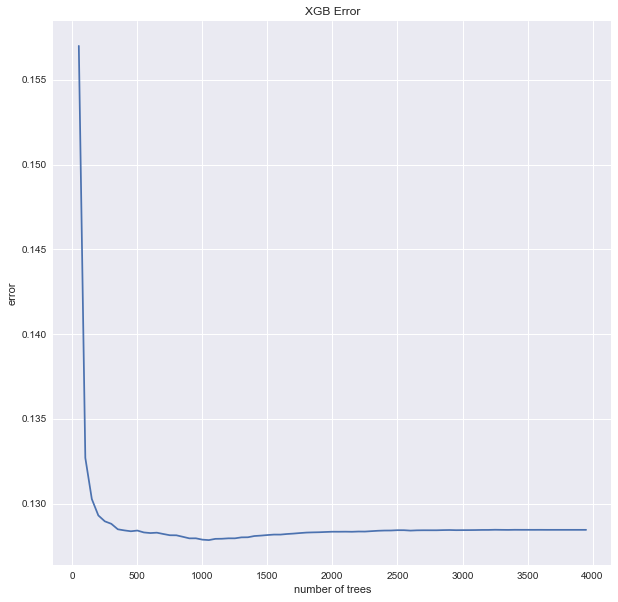

In [35]:
plt.figure(figsize=(10,10))
plt.plot(number_of_trees, rmse_scores_trees)
plt.xlabel('number of trees')
plt.ylabel('error')
plt.title('XGB Error')

#### XGBoost Построим модель с оптимальными параметрами

In [47]:
model_xgb = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=0, missing=None, n_estimators=3460, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=0, reg_alpha=6e-05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)

In [48]:
rmse_cv(model_xgb).mean()

0.12030696558039169

#### Предскажем значение целевой переменной с помощью алгоритма градиентного бустинга

In [49]:
print('Predict submission')
submission = pd.read_csv("../Data/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(model_xgb.predict(X_test)))
print(submission)

Predict submission
        Id      SalePrice
0     1461  124083.351562
1     1462  163496.484375
2     1463  187923.390625
3     1464  193549.015625
4     1465  185809.484375
5     1466  174961.281250
6     1467  173872.609375
7     1468  166509.203125
8     1469  188986.296875
9     1470  125976.585938
10    1471  195094.578125
11    1472   94854.203125
12    1473   95710.640625
13    1474  149966.203125
14    1475  121965.312500
15    1476  378725.718750
16    1477  251597.484375
17    1478  285977.531250
18    1479  250389.640625
19    1480  504218.437500
20    1481  330471.156250
21    1482  208363.765625
22    1483  167537.875000
23    1484  164179.125000
24    1485  176185.937500
25    1486  194221.140625
26    1487  342100.812500
27    1488  240105.718750
28    1489  206637.000000
29    1490  221686.046875
...    ...            ...
1429  2890   82594.507812
1430  2891  135911.296875
1431  2892   44480.234375
1432  2893   72485.070312
1433  2894   47205.917969
1434  2895  318572.

In [50]:
submission.to_csv('../Data/my_submission.csv', index = False)